# Neural Network Regularization and Dropout

## 0 - Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
from testCases import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 1 - Data Loading and Examination

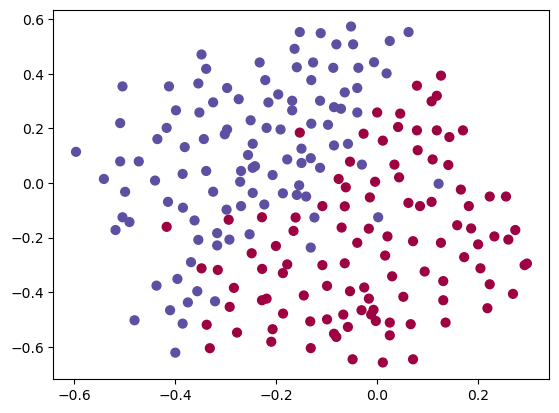

In [4]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Use deep learning model to classify the dots with two different colors.

## 2 - Dropout Scheme for 3-Layer Neural Network

The concept of `dropout` is to "kill" some neurons during each iteration. When the neuron is killed, it does not contribute to both forward and backward propagations.

### 2.1 Forward Propagation with Dropout

To implement `dropout` in the forward pass, we need to:

- define `keep_prob` as the `1 - dropout percentage` (e.g., if we want to dropout 20% neurons, then `keep_prob=0.8`)
- construct an auxiliary matrix $D^{[l]}$ with the same dimension with $A^{[l]}$, which is the values output by $l-th$ layer and should have the dimension of `(layer_size, num_samples)`
- each element in matrix $D^{[l]}$ is either ONE or ZERO, depending on the randomness. If a random number is greater than `keep_prob`, it is ONE. Otherwise, it's ZERO.
- calculate element-wise product: $A^{[l]} = D^{[l]} * A^{[l]}$. This step is equivalent to "kill" some neurons and force their corresponding result in $A^{[l]}$ to be ZERO.
- the last step is to $A^{[l]} = A^{[l]} /  \text{keep\_prob}$, which ensures that the loss calculated from dropout has the same expected value as the one without dropout scheme

In [5]:
def forward_propagation_with_dropout(X: np.ndarray, parameters: dict, keep_prob: float=0.5) -> tuple[float, tuple]:
    """
    Arguments:
    X: (2, number of examples)
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    keep_prob: float to define how likely a neuron is alive (oppoiste of being dropout)
    
    Returns:
    A3: the output from last layer sigmoid function
    cache: (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    """
    # Ensure the randomness can be replicated
    np.random.seed(1)
    # Get parameters
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    # 3-layer: linear + relu -> linear + relu -> linear + sigmoid
    # 1st layer with dropout
    Z1 = np.matmul(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = np.where(D1 < keep_prob, 1, 0)  # if keep_prob=0.8, we want 80% chance to be 1 and 20% to be 0
    A1 = A1 * D1
    A1 = A1 / keep_prob
    # 2nd layer with dropout
    Z2 = np.matmul(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = np.where(D2 < keep_prob, 1, 0)  # if keep_prob=0.8, we want 80% chance to be 1 and 20% to be 0
    A2 = D2 * A2
    A2 = A2 / keep_prob
    # 3rd layer without dropout because it only contains one neuron
    Z3 = np.matmul(W3, A2) + b3
    A3 = sigmoid(Z3)
    # Save for return
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    return A3, cache

`TEST`

In [6]:
t_X, parameters = forward_propagation_with_dropout_test_case()
A3, cache = forward_propagation_with_dropout(t_X, parameters, keep_prob=0.7)
A3

array([[0.36974721, 0.00305176, 0.04565099, 0.49683389, 0.36974721]])

### 2.2 Backward Propagation with Dropout

To implement the backward propagation with dropout, we will need to:

- apply the mask $D^{[l]}$ (generated from forward propagation) to $dA^{[l]}$ to obtain the updated $dA^{[l]}$. This is because if some neurons are dead, then their corresponding derivatives are also ZERO.
- calculate $dA^{[l]} / \text{keep\_prob}$. This is becasue if $A^{[l]}$ is scaled by $1 / \text{keep\_prob}$, then its derivative should also scaled by the same coefficient。

In [7]:
def backward_propagation_with_dropout(X: np.ndarray, Y: np.ndarray, cache: tuple, keep_prob: float):
    """
    Arguments:
    X: (2, number of examples)
    Y: (1, number of examples)
    cache: (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    keep_prob: float to denote how likely a neuron is alive
    
    Returns:
    gradients: {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    """
    # Get info
    num_samples = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    # Backward propagation - last layer - no dropout 
    dZ3 = A3 - Y
    dW3 = 1 / num_samples * np.matmul(dZ3, A2.T)
    db3 = 1 / num_samples * np.sum(dZ3, axis=1, keepdims=True)
    # Backward propagation - 2nd layer - with dropout
    dA2 = np.matmul(W3.T, dZ3)
    dA2 = D2 * dA2
    dA2 = dA2 / keep_prob
    dZ2 = dA2 * np.where(Z2 > 0, 1, 0)
    dW2 = 1 / num_samples * np.matmul(dZ2, A1.T)
    db2 = 1 / num_samples * np.sum(dZ2, axis=1, keepdims=True)
    # Backward propagation - 1st layer - with dropou
    dA1 = np.matmul(W2.T, dZ2)
    dA1 = D1 * dA1
    dA1 = dA1 / keep_prob
    dZ1 = dA1 * np.where(Z1 > 0, 1, 0)
    dW1 = 1 / num_samples * np.matmul(dZ1, X.T)
    db1 = 1 / num_samples * np.sum(dZ1, axis=1, keepdims=True)
    # Save for return
    gradients = {
        "dZ3": dZ3, "dW3": dW3, "db3": db3,
        "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, 
        "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

`TEST`

In [8]:
t_X, t_Y, cache = backward_propagation_with_dropout_test_case()
gradients = backward_propagation_with_dropout(t_X, t_Y, cache, keep_prob=0.8)
gradients['dA1'], gradients['dA2']

(array([[ 0.36544439,  0.        , -0.00188233,  0.        , -0.17408748],
        [ 0.65515713,  0.        , -0.00337459,  0.        , -0.        ]]),
 array([[ 0.58180856,  0.        , -0.00299679,  0.        , -0.27715731],
        [ 0.        ,  0.53159854, -0.        ,  0.53159854, -0.34089673],
        [ 0.        ,  0.        , -0.00292733,  0.        , -0.        ]]))

## 3 - Regularization for 3-Layer Neural Network

### 3.1 - Forward Propagation with Regularization

For binary classification, cross entropy function is used to measure the loss:

$$
\mathcal{L}(y^{(i)}, a^{(i)}) = -1.0 \cdot \frac{1}{n} \sum_{i=1}^n (y^{(i)} \log(a^{(i)}) + (1-y^{(i)}) \log(1-a^{(i)}))
$$

where $a^{(i)}$ is the $i$-th training sample's output of the last layer's activation function sigmoid

To enforce the regularization, the loss function will become:

$$
\mathcal{L}(y^{(i)}, a^{(i)}) = -1.0 \cdot \frac{1}{n} \sum_{i=1}^n (y^{(i)} \log(a^{(i)}) + (1-y^{(i)}) \log(1-a^{(i)})) + \frac{\lambda}{2n}\sum_l \sum_k \sum_j (W_{(i,j)}^{[l]})^2
$$

The last term is basically the summation of the square for each element in the weight matrix for all layers

Math background: `p-norm` for a vector/matrix is [link]((https://en.wikipedia.org/wiki/Norm_(mathematics))):

$$
||x||_p = (\sum_{i=1}^n |x_i|^p)^\frac{1}{p}
$$

In [9]:
def compute_cost_with_regularization(A3: np.ndarray, Y: np.ndarray, parameters: dict, regularization_coeff: float):
    """
    Arguments:
    A3: (1, num_samples)
    Y: (1, num_samples)
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    Returns:
    loss: loss function outcome
    """
    # Get info
    num_samples = Y.shape[1]
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]
    # Loss function - 1st term
    term1 = -1.0 / num_samples * (np.matmul(Y, np.log(A3).T) + np.matmul((1 - Y), np.log(1 - A3).T))
    # Loss function - 2nd term
    term2 = regularization_coeff / (2 * num_samples) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    # Total loss
    loss = np.squeeze(term1) + np.squeeze(term2)
    return loss

`TEST`

In [10]:
A3, t_Y, parameters = compute_cost_with_regularization_test_case()
loss = compute_cost_with_regularization(A3, t_Y, parameters, 0.1)
loss

1.7864859451590758

### 3.2 - Backward Propagation with Regularization

When implement the backward propagation, we only need to care about the gradients: $dW1$, $dW2$, $dW3$ by adding their corresponding regularized term's gradient: $\frac{\lambda}{n}W$

In [11]:
def backward_propagation_with_regularization(X: np.ndarray, Y: np.ndarray, cache: tuple, regularization_coeff: float):
    """
    Arguments:
    X: (2, num_samples)
    Y: (1, num_samples)
    cache: (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    Returns:
    gradients: {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    """
    # Get info
    num_samples = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    # Backward propagation - the last layer
    dZ3 = A3 - Y
    dW3 = 1 / num_samples * np.matmul(dZ3, A2.T) + regularization_coeff / num_samples * W3 
    db3 = 1 / num_samples * np.sum(dZ3, axis=1, keepdims=True)
    # Backward propagation - the 2nd layer
    dA2 = np.matmul(W3.T, dZ3)
    dZ2 = dA2 * np.where(Z2 > 0, 1, 0)
    dW2 = 1 / num_samples * np.matmul(dZ2, A1.T) + regularization_coeff / num_samples * W2
    db2 = 1 / num_samples * np.sum(dZ2, axis=1, keepdims=True)
    # Backward propagation - the 1st layer (not input layer)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * np.where(Z1 > 0, 1, 0)
    dW1 = 1 / num_samples * np.dot(dZ1, X.T) + regularization_coeff / num_samples * W1
    db1 = 1 / num_samples * np.sum(dZ1, axis=1, keepdims=True)
    # Save for return
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

In [12]:
t_X, t_Y, cache = backward_propagation_with_regularization_test_case()
grads = backward_propagation_with_regularization(t_X, t_Y, cache, 0.7)
grads['dW1'], grads['dW2'], grads['dW3']

(array([[-0.25604646,  0.12298827, -0.28297129],
        [-0.17706303,  0.34536094, -0.4410571 ]]),
 array([[ 0.79276486,  0.85133918],
        [-0.0957219 , -0.01720463],
        [-0.13100772, -0.03750433]]),
 array([[-1.77691347, -0.11832879, -0.09397446]]))

## 4 - Three-Layer Neural Network Model

### 4.1 Neural Network Model Generic Construction

In [13]:
def model(X: np.ndarray, Y: np.ndarray, learning_rate: float=0.3, num_iterations: int=30000, regularization_coeff: float=0.0, keep_prob: float=1.0):
    """
    Three layer neural network model: linear + relu -> linear + relu -> linear + sigmoid

    Arguments:
    X: (2, num_samples)
    Y: (1, num_samples)
    learning_rate: float to denote the learning step size
    num_iterations: int to maximum number of training loops
    regularization_coeff: float to denote the lambda in regularization term
    keep_prob: float to denote how likely a neuron is alive
    
    Returns:
    parameters: {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    """
    # Validate arguments
    assert 0.0 < keep_prob <= 1.0, f'{keep_prob} must be between (0, 1].'
    assert regularization_coeff >= 0, f'{regularization_coeff} must be non-negative number.'
    assert keep_prob == 1.0 or regularization_coeff == 0, f'Current model only allow to use EITHER dropout OR regularization, NOT both.'
    # Get info
    grads, losses = {}, []
    num_samples = X.shape[1]
    layers_size = [2, 20, 3, 1]
    # Step - 0: Initialize parameters
    parameters = initialize_parameters(layers_size)
    # Training loop for gradient descent
    for idx in range(0, num_iterations):
        # Step - 1: forward pass (regularization does NOT affect forward pass; ONLY drop affect)
        if keep_prob < 1.0:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        else:
            a3, cache = forward_propagation(X, parameters)
        # Step - 2: calculate the loss
        if regularization_coeff > 0:
            loss = compute_cost_with_regularization(a3, Y, parameters, regularization_coeff)
        else:
            loss = compute_cost(a3, Y)
        # Step - 3: backward pass
        if regularization_coeff == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif regularization_coeff != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, regularization_coeff)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        else:
            pass
        # Step - 4: update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        # Step - 5: document training process
        if idx % 10000 == 0 or idx == num_iterations-1:
            print(f'Loss after iteration {idx}: {loss:.8f}')
        if idx % 1000 == 0 or idx == num_iterations-1:
            losses.append(loss)
    # Visualize training process
    plt.figure(figsize=(5,4))
    plt.plot(losses)
    plt.ylabel('loss')
    plt.xlabel('iterations (1,000)')
    plt.title("Loss variation with iterations")
    plt.show()
    return parameters

### 4.2 Training without Dropout and without Regularization

`Training Process`

Loss after iteration 0: 0.65574125
Loss after iteration 10000: 0.16329988
Loss after iteration 20000: 0.13851642
Loss after iteration 29999: 0.12509131


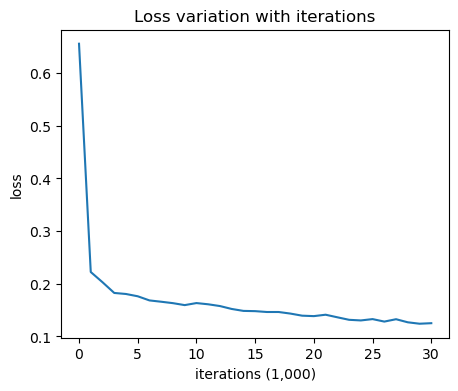

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [14]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

`Decision Boundary`

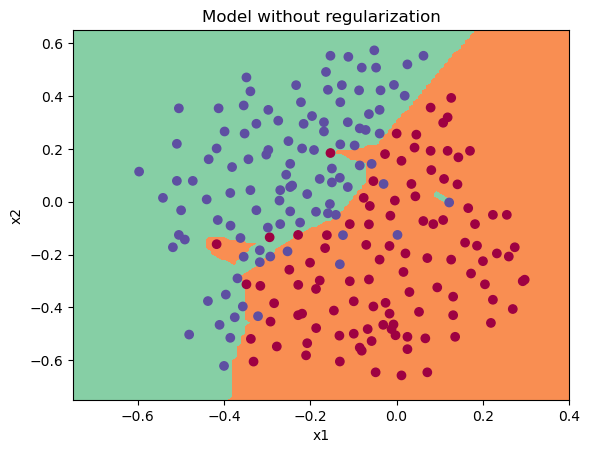

In [15]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Without regularization and dropout, the decision boundary seems to curvy and thus overfit the data a bit.

### 4.3 Training with Regularization

Loss after iteration 0: 0.69744845
Loss after iteration 10000: 0.26849189
Loss after iteration 20000: 0.26809163
Loss after iteration 29999: 0.26786174


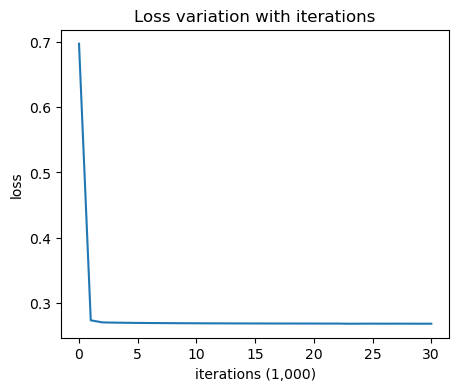

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [16]:
parameters = model(train_X, train_Y, regularization_coeff = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

`Decision Boundary`

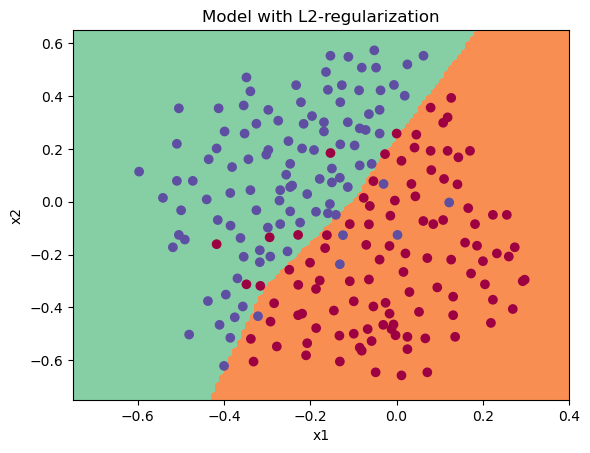

In [17]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

After using dropout, the decision boundary is smooth and not fitted into noise (outliers).

### 4.4 Training with Dropout

`Training`

Loss after iteration 0: 0.65439124
Loss after iteration 10000: 0.06101699
Loss after iteration 20000: 0.06058244
Loss after iteration 29999: 0.06048818


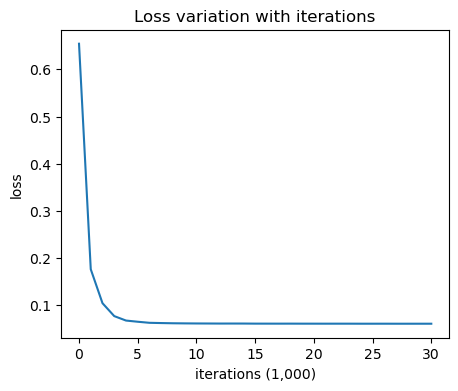

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [18]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

`Decision Boundary`

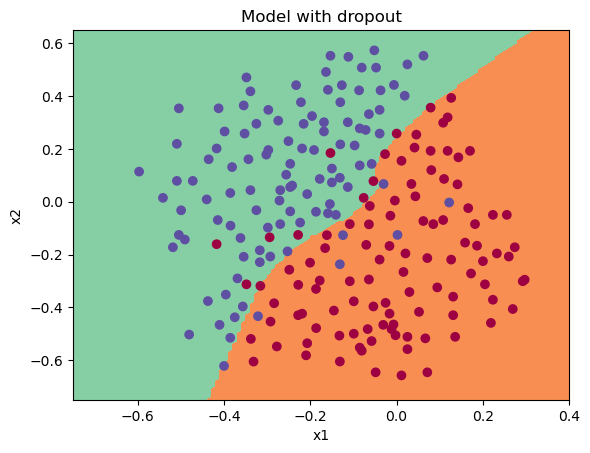

In [19]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

After using regularization, the decision boundary is smooth and not fitted into noise (outliers).

## 5 - Conclusion

### 5.1 Dropout

Highlights:

- `Dropout` is ONLY used in training, NOT testing stage.
- `Dropout` affects the forward propagation:
    - It kills the neurons, so the corresponding output should be ZERO
    - Meanwhile, the output from each layer should be scaled up by $1 / \text{keep\_prob}$ to compensate the reduction caused by killing neurons
- `Dropout` affects the backward propagation:
    - The dead neuron's corresponding gradient should also be set as ZERO
    - The gradient at each layer should also be scaled up by $1 / \text{keep\_prob}$ because the forward pass did so

### 5.2 Regularization

Highlights:

- `L2 regularization` shrinks the weight parameters towards ZERO
- `L2 regularization` assumes that a model with small weight parameters is SIMPLER than a model with large weight parameters
- Once the weight parameter is small, the variation in the input leads to minor change in the output, thus reducing the "variance" (sensitive to input training)
- `L2 regularization` affects the forward propagation:
    - It adds a penalty term in the loss function
- `L2 regularization` affects the backward propagation:
    - It adds additional term corresponding to penalty term in when computing the gradients